# Generate 1D periodic data

In [1]:
import numpy as np

def gaussian(x, A, u, s):
    return A * np.exp(-((x - u)/s)**2/2)/(np.sqrt(2*np.pi)*s)

def wrap_gaussian(x, A, u, s):
    in_dis = np.abs(x-u)
    x_dis = np.minimum(in_dis, 1-in_dis)
    return gaussian(x_dis, A, 0, s)

def range_sampling(value_range, size):
    return np.random.random(size = size) * (value_range[1] - value_range[0]) + value_range[0]

In [2]:
data_num = 1024
n_max = 7
A_range = [0.00, 5.00]
u_range = [0.00, 1.00]
s_range = [0.01, 0.02]

In [3]:
x = np.linspace(0.0, 1.0, 257)[:-1]
As = range_sampling(A_range, (data_num, 1, n_max))
us = range_sampling(u_range, (data_num, 1, n_max))
ss = range_sampling(s_range, (data_num, 1, n_max))

In [4]:
data = np.sum(wrap_gaussian(x.reshape(1, -1, 1), As, us, ss), axis = -1)

# Visualize a data sample

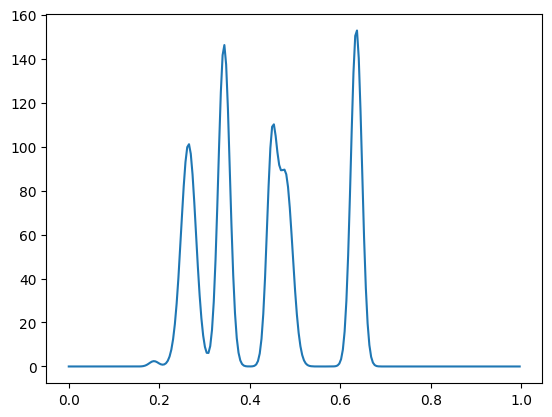

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(x, data[0])
plt.show()

# 1D Periodic Autoencoder Class

In [6]:
import torch
import torch.nn as nn

In [7]:
torch.set_default_dtype(torch.float64)

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the CPU


In [9]:
def PConv1d(in_channels, out_channels, padding):
    return nn.Sequential(
                            nn.CircularPad1d(padding),
                            nn.Conv1d(in_channels, out_channels, 2*padding+1)
                        )

In [10]:
class PEncoder(nn.Module):
    def __init__(self, platent_dim):
        super(PEncoder, self).__init__()

        self.net = nn.Sequential(
                                    PConv1d(1, 1, 1),   # 256
                                    nn.LeakyReLU(),
                                    nn.MaxPool1d(2, 2),
                                    PConv1d(1, 2, 1),   # 128
                                    nn.LeakyReLU(),
                                    nn.MaxPool1d(2, 2),
                                    PConv1d(2, 2, 2),   # 64
                                    nn.LeakyReLU(),
                                    nn.MaxPool1d(2, 2),
                                    PConv1d(2, 4, 2),   # 32
                                    nn.LeakyReLU(),
                                    nn.MaxPool1d(2, 2),
                                    PConv1d(4, 4, 2),   # 16
                                    nn.LeakyReLU(),
                                    nn.MaxPool1d(2, 2),
                                    PConv1d(4, 8, 2),   # 8
                                    nn.LeakyReLU(),
                                    nn.MaxPool1d(2, 2),
                                    PConv1d(8, 16, 1),  # 4
                                    nn.LeakyReLU(),
                                    nn.MaxPool1d(2, 2),
                                    PConv1d(16, 32, 1), # 2
                                    nn.LeakyReLU(),
                                    nn.MaxPool1d(2, 2),
                                    nn.Flatten(),
                                    nn.Linear(32, platent_dim),
                                    nn.LeakyReLU()
                                )
    
    def forward(self, x):
        x = x.view(-1, 1, 256)
        output = self.net(x)
        return output

In [11]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()

        self.net = nn.Sequential(
                                    nn.Conv1d(1, 1, 3, padding = 1), # 256
                                    nn.LeakyReLU(),
                                    nn.MaxPool1d(2, 2),
                                    nn.Conv1d(1, 1, 3, padding = 1), # 128
                                    nn.LeakyReLU(),
                                    nn.MaxPool1d(2, 2),
                                    nn.Conv1d(1, 1, 3, padding = 1), # 64
                                    nn.LeakyReLU(),
                                    nn.MaxPool1d(2, 2),
                                    nn.Flatten(),
                                    nn.Linear(32, latent_dim),
                                    nn.LeakyReLU()
                                 )
    
    def forward(self, x):
        x = x.view(-1, 1, 256)
        output = self.net(x)
        return output

In [12]:
class Decoder(nn.Module):
    def __init__(self, platent_dim, latent_dim):
        super(Decoder, self).__init__()
        self.linear = nn.Sequential(
                                    nn.Linear(platent_dim + latent_dim, 32),
                                    nn.LeakyReLU()
                                    )
        
        self.convt = nn.Sequential(
                                    nn.Upsample(scale_factor = 2, mode = 'nearest'),    # 1
                                    nn.Conv1d(32, 16, 3, padding = 1),
                                    nn.LeakyReLU(),
                                    nn.Upsample(scale_factor = 2, mode = 'nearest'),    # 2
                                    nn.Conv1d(16, 8, 3, padding = 1),
                                    nn.LeakyReLU(),
                                    nn.Upsample(scale_factor = 2, mode = 'nearest'),    # 4
                                    nn.Conv1d(8, 4, 5, padding = 2),
                                    nn.LeakyReLU(),
                                    nn.Upsample(scale_factor = 2, mode = 'nearest'),    # 8
                                    nn.Conv1d(4, 4, 5, padding = 2),
                                    nn.LeakyReLU(),
                                    nn.Upsample(scale_factor = 2, mode = 'nearest'),    # 16
                                    nn.Conv1d(4, 2, 5, padding = 2),
                                    nn.LeakyReLU(),
                                    nn.Upsample(scale_factor = 2, mode = 'nearest'),    # 32
                                    nn.Conv1d(2, 2, 5, padding = 2),
                                    nn.LeakyReLU(),
                                    nn.Upsample(scale_factor = 2, mode = 'nearest'),    # 64
                                    nn.Conv1d(2, 1, 3, padding = 1),
                                    nn.LeakyReLU(),
                                    nn.Upsample(scale_factor = 2, mode = 'nearest'),    # 128
                                    nn.Conv1d(1, 1, 3, padding = 1),
                                    nn.LeakyReLU()
                                   )
        
    def forward(self, x):
        output = self.linear(x)
        output = output.view(-1, 32, 1)
        output = self.convt(output)
        return output

In [13]:
class PAE(nn.Module):
    def __init__(self, encoder, pencoder, decoder):
        super(PAE, self).__init__()
        self.pencoder = pencoder
        self.encoder = encoder
        self.decoder = decoder

        self.pencoder.to(device)
        self.encoder.to(device)
        self.decoder.to(device)

    def forward(self, x):
        encoded = self.encoder(x)
        pencoded = self.pencoder(x)
        decoded = self.decoder(torch.concat([pencoded, encoded], dim = 1))
        return decoded

# Trainging Manager Class

In [14]:
from torch.utils.data import DataLoader

class Demo():
    def __init__(self, pae):
        self.network = pae
        self.optim = torch.optim.Adam(self.network.parameters(), lr = 0.1)

    def train(self, loss_fn, epochs, batch_size, dataset):

        def init_weights(module):
            if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                module.bias.data.fill_(0.01)

        self.network.apply(init_weights)

        loader = DataLoader(dataset, batch_size)

        self.network.to(device)

        epoch_losses = []

        for epoch in range(epochs):
            self.network.train()
            batch_losses = []
            for batch_data in loader:
                

                batch_data = batch_data.to(device)

                output = self.network(batch_data)
                loss = loss_fn(output, batch_data.view(-1, 1, 256))

                self.optim.zero_grad()
                loss.backward()
                self.optim.step()
                batch_losses.append(loss.item())

            epoch_losses.append(np.mean(batch_losses))
            print(f'Epoch {epoch + 1}/{epochs}, loss: {np.round(epoch_losses[-1], 4)}', end = '\r')

        plt.figure()
        plt.plot(epoch_losses)
        plt.show()


# Train

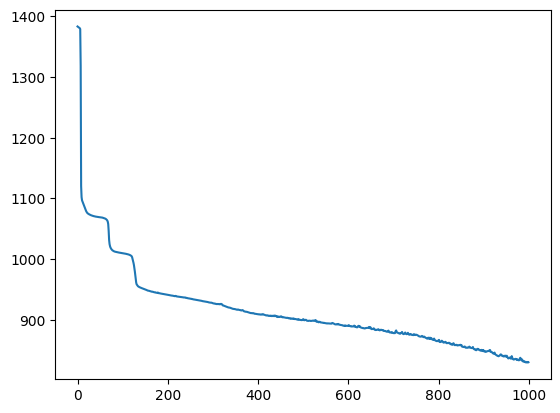

In [15]:
model = Demo(PAE(Encoder(2), PEncoder(32), Decoder(32, 2)))

model.train(nn.MSELoss(), 1000, 64, data)

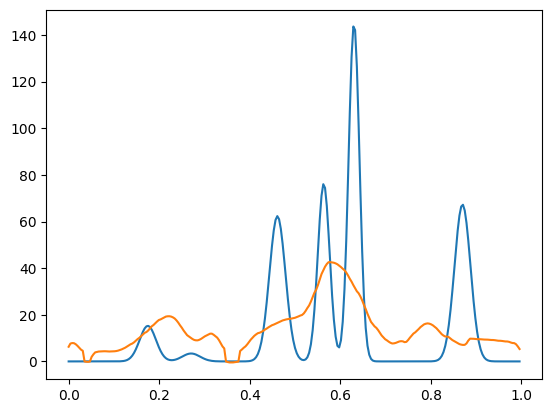

In [61]:
plt.figure()
plt.plot(x, data[100])
plt.plot(x, model.network(torch.from_numpy(data[100])).detach().numpy().flatten())
plt.show()

In [62]:
a = model.network.pencoder(torch.from_numpy(data[100]))

In [63]:
b = model.network.pencoder(torch.from_numpy(np.roll(data[100], shift = 64)))

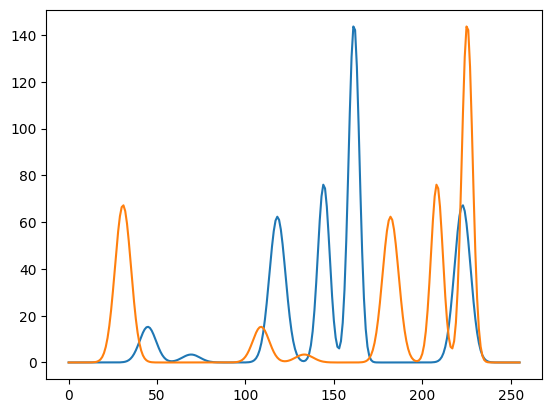

In [64]:
plt.figure()
plt.plot(data[100])
plt.plot(np.roll(data[100], shift = 64))
plt.show()

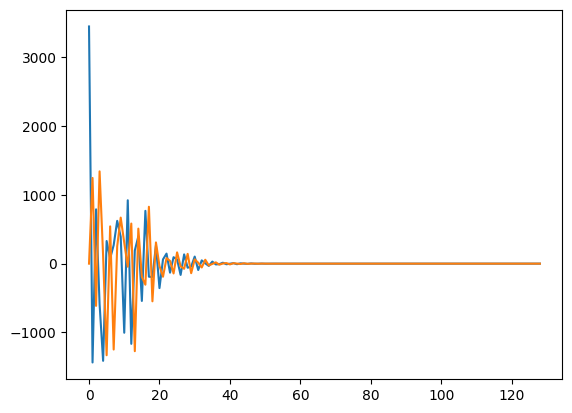

In [69]:
plt.figure()
plt.plot(np.real(np.fft.rfft(data[100])))
plt.plot(np.imag(np.fft.rfft(data[100])))
# plt.plot(np.roll(data[100], shift = 64))
plt.show()

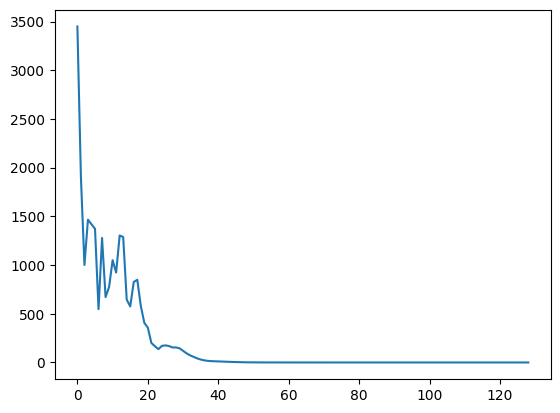

In [71]:
plt.figure()
plt.plot(np.abs(np.fft.rfft(data[100])))
# plt.plot(np.roll(data[100], shift = 64))
plt.show()

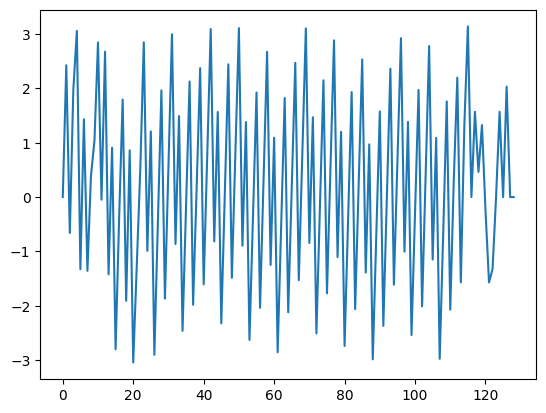

In [72]:
plt.figure()
plt.plot(np.angle(np.fft.rfft(data[100])))
# plt.plot(np.roll(data[100], shift = 64))
plt.show()

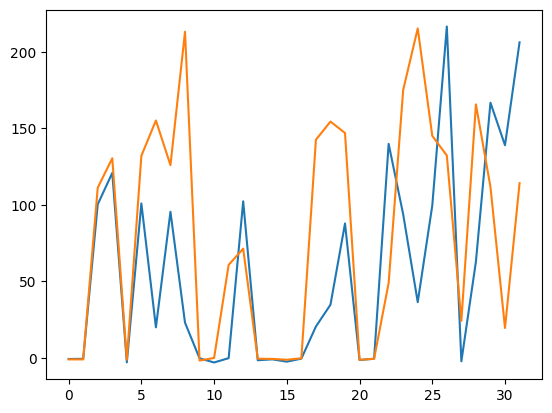

In [65]:
plt.figure()
plt.plot(a.detach().numpy().flatten())
plt.plot(b.detach().numpy().flatten())
plt.show()